<a href="https://colab.research.google.com/github/Tyanakai/religious_art/blob/main/religious_art_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>宗教画テーマの分類　データ分析</h1>

# 1.はじめに
本ノートブックは、ProbSpace上で開催された[宗教画テーマの分類](https://comp.probspace.com/competitions/religious_art)で使用されるデータを分析しjpg形式で保存します。<br>
また、クラスタ分析する事で、データ内で重複した画像を調べ処理します。<br>

尚、colabratory上で、ランタイムのタイプをGPUに設定した状態での実行を想定しています。

# 2.事前に準備していること

 `/content/drive/MyDrive/portforio/religious_art/input`にデータをアップロード
- 訓練データ(`christ-train-imgs.npz`)
- 訓練データラベル(`christ-train-labels.npz`)
- テストデータ(`christ-test-imgs.npz`)

# 3.コンペティションの概要
コンペティションのタスクは画像を入力として、その画像が所属するクラス(13種類)を予測する多クラス単一ラベル問題です。<br>
評価はaccuracy(正解数/全サンプル数)によって行われます。

# 4.環境準備
実行環境を構築します。

## 4.1 ライブラリ
使用するライブラリを準備します。<br>
EfficientNetB0はクラスタ分析の際、特徴ベクトルの抽出に使用します。

In [ ]:
!pip install -q efficientnet

import os

from efficientnet.tfkeras import EfficientNetB0
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm

     |████████████████████████████████| 50 kB 4.1 MB/s 


## 4.2 GPU
GPUを確認します。

In [ ]:
!nvidia-smi

Wed Nov 10 11:22:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 4.3 Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 4.3 path
pathを設定し、フォルダを作成します。

In [ ]:
DRIVE = "/content/drive/MyDrive/portforio/religious_art"

INPUT = os.path.join(DRIVE, "input")
OUTPUT = os.path.join(DRIVE, "output")

DRIVE_TRAIN = os.path.join(OUTPUT, "train_image")
DRIVE_TEST = os.path.join(OUTPUT, "test_image")
DRIVE_PSEUDO = os.path.join(OUTPUT, "pseudo_image")

for folder in [INPUT, OUTPUT, DRIVE_TRAIN, DRIVE_TEST, DRIVE_PSEUDO]:
    os.makedirs(folder, exist_ok=True)

# 5.データ分析
後に行う前処理の為に、画像行列の値の分布とクラスの分布状を確認します。

## 5.1 データロード

In [ ]:
train_imgs =  np.load(os.path.join(INPUT, "christ-train-imgs.npz"))["arr_0"]
train_labels = np.load(os.path.join(INPUT, "christ-train-labels.npz"))["arr_0"]
test_imgs = np.load(os.path.join(INPUT, "christ-test-imgs.npz"))["arr_0"]

all_imgs = np.concatenate((train_imgs, test_imgs), axis=0)

## 5.2 画像データ概観

In [ ]:
print(f"train shape: {train_imgs.shape}\ntest shape: {test_imgs.shape}")

train shape: (654, 224, 224, 3)
test shape: (497, 224, 224, 3)


In [ ]:
print("train画像行列：平均値 {:.4f}, 最大値 {:.4f}, 最小値 {:.4f}".format(
    np.mean(train_imgs),np.max(train_imgs), np.min(train_imgs)
    ))

train画像行列：平均値 141.8436, 最大値 255.0000, 最小値 0.0000


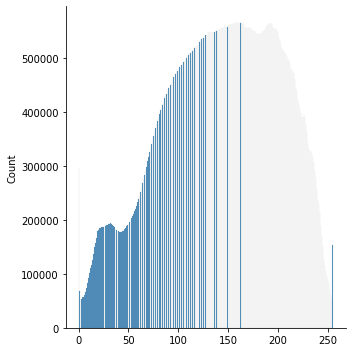

In [ ]:
# train画像行列の値の分布
sns.displot(train_imgs.flatten())

In [ ]:
print("test画像行列：平均値 {:.4f}, 最大値 {:.4f}, 最小値 {:.4f}".format(
    np.mean(test_imgs),np.max(test_imgs), np.min(test_imgs)
    ))

test画像行列：平均値 141.0363, 最大値 255.0000, 最小値 0.0000


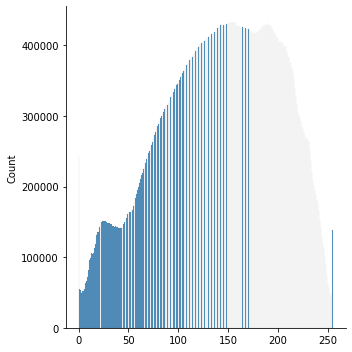

In [ ]:
# test画像行列の値の分布
sns.displot(test_imgs.flatten())

## 5.3 クラス分布

In [ ]:
# 訓練データの正解ラベルの分布
pd.DataFrame(train_labels).value_counts(sort=False)

0      60
1      42
2     132
3      42
4      42
5      60
6      48
7      30
8      30
9      66
10     30
11     42
12     30
dtype: int64

In [ ]:
pd.DataFrame(train_labels).value_counts(normalize=True, sort=False)

0     0.091743
1     0.064220
2     0.201835
3     0.064220
4     0.064220
5     0.091743
6     0.073394
7     0.045872
8     0.045872
9     0.100917
10    0.045872
11    0.064220
12    0.045872
dtype: float64

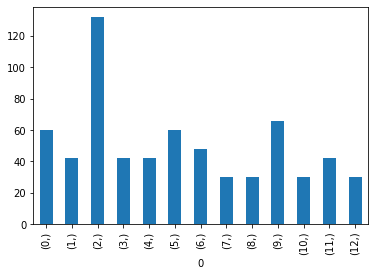

In [ ]:
pd.DataFrame(train_labels).value_counts(sort=False).plot.bar()

# 6.データ保存
目視での画像確認とモデル訓練の為に、画像のnumpy配列をjpg形式で保存します。<br>
加えて、重複画像を抽出する為、画像をクラスタ分析し、クラスタ毎にフォルダに分けて保存します。

## 6.1 train image

In [ ]:
num_img = train_imgs.shape[0]

for idx in tqdm(range(num_img)):
    img = Image.fromarray(train_imgs[idx])
    img.save(os.path.join(DRIVE_TRAIN, f"train_img{idx:0>3d}.jpg"), 
             quality=95)

  0%|          | 0/654 [00:00<?, ?it/s]

## 6.2 test image

In [ ]:
num_img = test_imgs.shape[0]

for idx in range(num_img):
    img = Image.fromarray(test_imgs[idx])
    img.save(os.path.join(DRIVE_TEST, f"test_img{idx:0>3d}.jpg"),
             quality=95)

## 6.3 クラスタ分析、保存
事前学習済みのモデルを用いて、画像を特徴ベクトル化し、<br>
そのベクトルをk-means法で、50個のクラスタに分割します。<br>
特徴ベクトルの似た画像を収集することで、目視での重複画像の発見を補助します。

In [ ]:
# tf.data.Dataset化する関数
def load_and_process(array, label=None):
    array = tf.cast(array, tf.float32) / 255.0
    return array, label

def image_dataset(arrays, labels=None, batch_size=16):
    img_ds = tf.data.Dataset.from_tensor_slices((arrays, labels))
    img_ds = img_ds.map(load_and_process, num_parallel_calls=-1)
    img_ds = img_ds.batch(batch_size)
    img_ds = img_ds.prefetch(-1)
    return img_ds

In [ ]:
# EfficientNetを使用
pretrained_model = EfficientNetB0(weights="noisy-student", include_top=False)

# dataset準備
img_ds = image_dataset(all_imgs)

# 特徴ベクトル抽出
feat = pretrained_model.predict(img_ds, verbose=1)
reshaped_feat = feat.reshape([all_imgs.shape[0],-1])

# k-means法でクラスタ分析
n_cluster = 50
km_cluster = KMeans(n_clusters=n_cluster, random_state=21)
km_cluster.fit(reshaped_feat)
km_cluster.labels_

72/72 [==============================] - 34s 60ms/step


array([19, 33, 26, ..., 28,  5,  6], dtype=int32)

In [ ]:
# all_imgsの順にクラスタラベルを格納したリスト
cluster_labels = km_cluster.labels_

# クラスタフォルダを置く場所
CLUSTER = os.path.join(OUTPUT, "cluster")

for i in tqdm(range(50)):
    # クラスタ毎にフォルダを作成
    cluster_path = os.path.join(CLUSTER, f"cluster{i}")
    if not os.path.exists(cluster_path):
        os.makedirs(cluster_path)

    # クラスタに該当する画像の取得、保存
    ids = np.where(cluster_labels==i)[0]
    for idx in ids:
        img = Image.fromarray(all_imgs[idx])
        img.save(os.path.join(cluster_path, f"image{idx}.jpg"), quality=95)

  0%|          | 0/50 [00:00<?, ?it/s]

# 7.重複画像
上記でクラスタ毎にフォルダ分けして保存した画像から発見した重複画像を表示します。<br>
交差検証時trainデータとvalidationデータに跨って重複する事を避ける為、<br>
trainデータから、重複画像のindexを取り除いたindexリストを作成保存します。

In [ ]:
# 同一画像のindexを一つのタプルとし、それらをリスト化したもの。
same_image = [(50, 1129), (506, 598), (138, 793), (9, 66), (250, 1011),
                (238, 341, 415), (75, 772), (71, 535), (333, 513),
                (163, 443), (894, 898), (414, 893), (661, 880), (121, 1067),
                (321, 825), (424, 953), (30, 773), (122, 545)]

## 7.1 表示

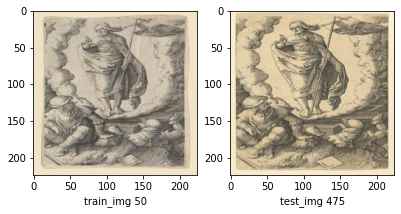

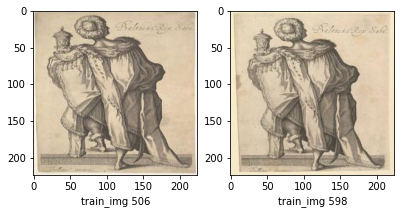

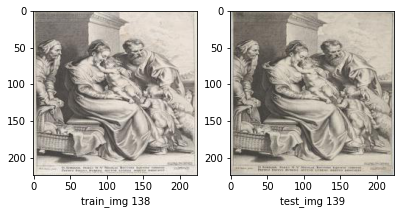

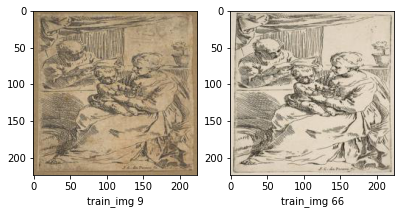

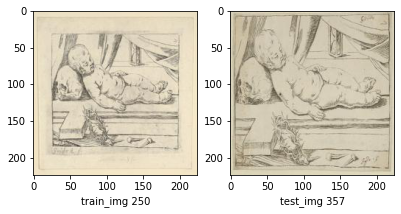

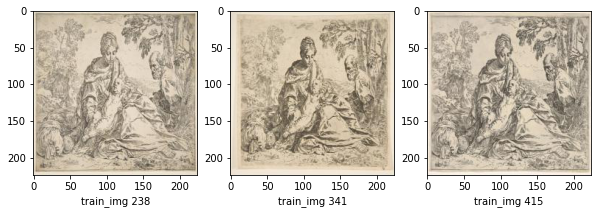

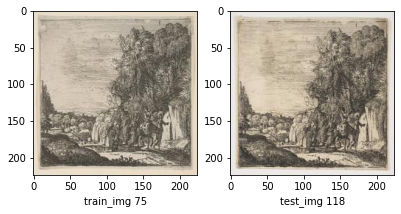

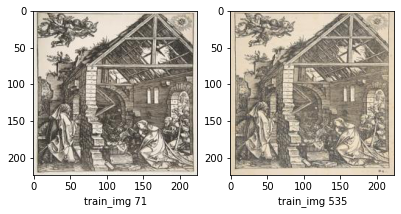

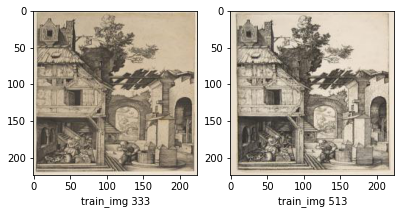

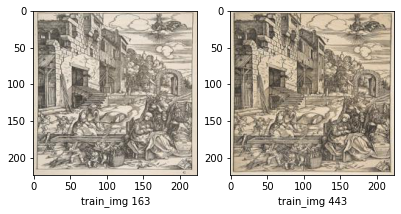

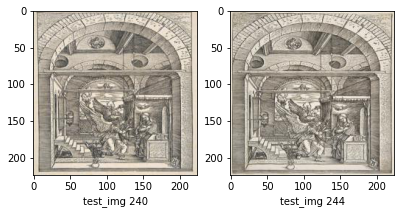

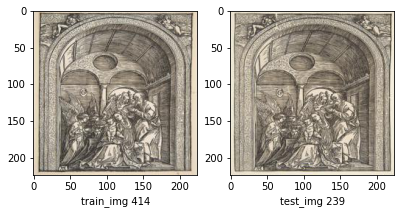

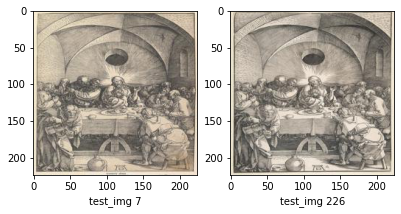

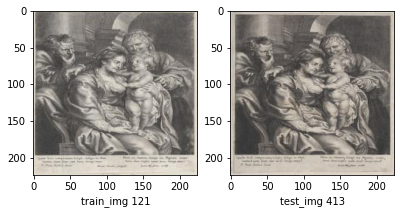

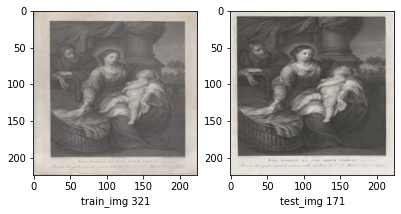

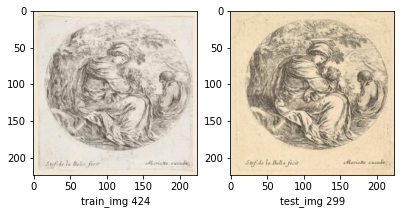

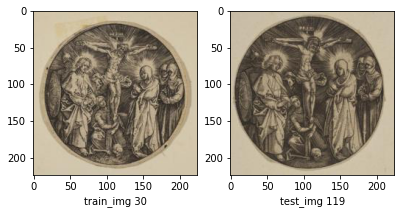

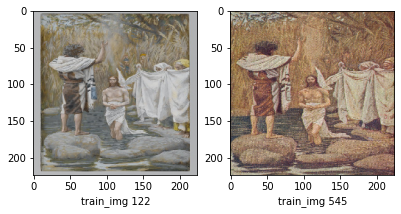

In [ ]:
num_train_img = train_imgs.shape[0]

def plot_img(plt_pos, idx, num_train_img):
    """
    重複画像を並べて表示する。
    入力されたindexによって、trainデータかtestデータかを判定し、
    位置を指定して画像を表示。
    """
    plt.subplot(1, 3, plt_pos+1)

    if idx > num_train_img:
        plt.imshow(test_imgs[idx - num_train_img])
        plt.xlabel(f"test_img {idx - num_train_img}")
    else:
        plt.imshow(train_imgs[idx])
        plt.xlabel(f"train_img {idx}")

for tpl in same_image:
    plt.figure(figsize=(10,15))
    for i, idx in enumerate(tpl):
        plot_img(i, idx, num_train_img)

## 7.2 排他的indexリスト作成保存
trainデータのindexから重複画像のindexを取り除き、リストとして保存します。<br>
その際、一種類の重複につき、一つのindexだけを残します。

In [ ]:
# same_image内のそれぞれのタプルについて、2番目以降のindexだけを取り出したもの
dup_idx = []
for tpl in same_image:
    for idx in tpl[1:]:
        dup_idx.append(idx)

np.save(os.path.join(OUTPUT, "dup_idx.npy"), dup_idx)
dup_idx

[1129,
 598,
 793,
 66,
 1011,
 341,
 415,
 772,
 535,
 513,
 443,
 898,
 893,
 880,
 1067,
 825,
 953,
 773,
 545]

In [ ]:
# trainデータのindexからsame_idxにあるindexを取り除く
ex_image_idx = set(idx for idx in range(num_train_img)) - set(dup_idx)
exclusive_train_idx = np.array(list(ex_image_idx))

# クラス分布を再確認
pd.DataFrame(train_labels[exclusive_train_idx]).value_counts(sort=False)
# クラス：7, 8, 10, 12の訓練データが比較的少ない

0      60
1      40
2     130
3      42
4      41
5      58
6      47
7      30
8      30
9      66
10     30
11     42
12     30
dtype: int64